In [ ]:
!pip install pandas
!pip install matplotlib
!pip install shapely
!pip install torch
!pip install imageio


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [18]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Є 14 базових станцій звʼязку. Кожна станція звʼязку представлена як точка в умовному 2-х вимірному просторі. У кожної станції є параметр радіусу покриття сигналом. Радіус покриття знаходиться у діапазоні від 1 до 2. У свою чергу простір, у якому ми працюємо, є обмеженим (10 на 10) та має ідеальну квадратну форму.

init_vars:
N = 14
Radius constrains = [1,2]
Space_max_x = 10
Space_max_y = 10

Завдання - знайти спосіб оптимально розмістити всі базові станції у заданому просторі, переміщуючи їх. Важливо, що центр станції має знаходитись усередині заданого простору. Критерії оптимальності розміщення потрібно обґрунтувати. 

![alt text](image.png)

In [84]:
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from task_1_vis_utils import StantionsVisualizer, save_as_gif

In [24]:
task_path = "Test task (Operations Research Scientist) (1).xlsx"
stantions_data = pd.read_excel(task_path, sheet_name="data_1")
stantions_data

tower_id  tower_connection_radius  center_x_coordinate  \
0          1                 1.965303             1.888206   
1          2                 1.450103             0.137959   
2          3                 1.107741             6.798469   
3          4                 1.510576             1.004215   
4          5                 1.854738             6.406148   
5          6                 1.967446             5.554132   
6          7                 1.682968             8.427423   
7          8                 1.604408             6.977879   
8          9                 1.390795             1.755246   
9         10                 1.402366             8.884966   
10        11                 1.291950             0.661559   
11        12                 1.943895             6.381678   
12        13                 1.209900             4.155997   
13        14                 1.399222             2.780755   

    center_y_coordinate  
0              8.719218  
1              0.948010  
2              6.937930  
3              6.075564  
4              8.924267  
5              7.739135  
6              4.916873  
7              9.620095  
8              7.342749  
9              4.374669  
10             8.198121  
11             4.509644  
12             0.903246  
13             9.849256

# EDA

Найочевиднішим критерієм "оптимальності" є % покриття -> мінімазація НЕ покритої площі квадрата станціями. 

Проте, в такому випадку в нас цілком ймовірно буде багато "прогалин" (не покрита площа) по всій площі квадрату. 

Якщо припустити, що в центрі квадрату якийсь населений пункт, тоді окрім загалом великого % покриття, потрібно мінімізувати прогалини в центрі.

Далі буде додана можливість зважувати зони квадрату, тим самим спонукати алгоритм звертати на них більшу увагу.

Оскільки вивести аналітичну формулу яка б розраховувала покриту/не покриту площу кругами, які можуть перетинатись і які мають також перетинатись з квдаратом - дуже важко, був вибраний чисельний метод:
1. Розбиваємо квадрат на сітку потрібної точності
2. Для кожної точки сітки перевіряєм чи вона покривається кругом:
    
    Оскільки нам потрібно диференційоване представлення, ми можемо використати сігмоїду від різниці радіуса і відстані від точки до центру круга ```delta_ij_c```, де ```ij``` - координати/індекс точки в сітці, а ```c``` - номер круга, ```R_c``` - радіус круга ```с```, ```D_ij_c``` - відставнь від точки ```ij``` до центру круга ```c``` - таким чином якщо точка лежить за межами круга, то ```R_c < D_ij_c => delta_ij_c < 0``` і навпаки. Звідси ```Coverege_prob_ij_c = sigmoid(delta_ij_c)```
3. Маючи таке предаставлення для точок відносно кругів, можна вивести наступний loss: 

    3.1. Для кожної точки брати максимальне значення по кругу - таким чином, для нас досттаньо мати покриття хоча б одним кругом і з іншої сторони ми не будемо ніяк враховувати покриття кількома кругами

    3.2. Піднести до квадрату ймовірність, щоб підсилити різницю між покритим і не покритим
    
    3.3. Усереднити всі ймовірності

True


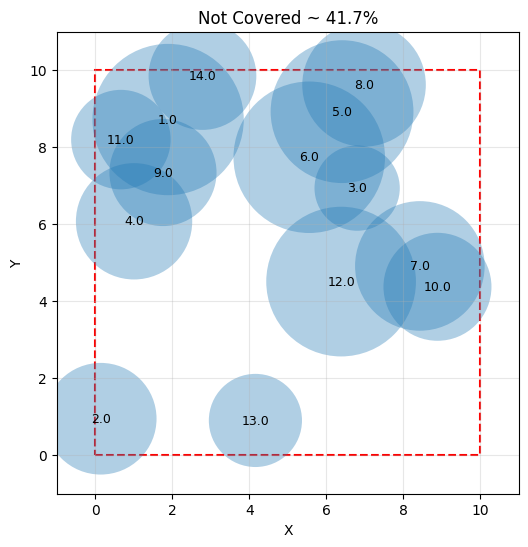

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Not Covered ~ 41.7%'}, xlabel='X', ylabel='Y'>)

In [25]:
vis = StantionsVisualizer(
    init_stantions_data=stantions_data,
    space_size=(10,10)
)
vis.visualize_stantions()

In [86]:

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from copy import deepcopy
from torch.optim.lr_scheduler import ReduceLROnPlateau


def create_importance_weights(grid_size: int = 250, sigma: float = 50.0):
    """
    Створює матрицю ваг на основі Гауссового ядра з центром посередині сітки.
    """
    coords = torch.linspace(0, grid_size - 1, grid_size)
    
    # Генеруємо сітку координат (X та Y)
    grid_y, grid_x = torch.meshgrid(coords, coords, indexing='ij')
    center = (grid_size - 1) / 2.0
    dist_sq = (grid_x - center)**2 + (grid_y - center)**2    
    # формула Гаусса:
    # W = exp(-d^2 / (2 * sigma^2))
    importance_map = torch.exp(-dist_sq / (2 * sigma**2))
    importance_map = importance_map / importance_map.mean()
    
    return importance_map


class OptimizeCoverege:
    def __init__(self,
                 initial_data: pd.DataFrame,
                 resolution: int = 250,
                 steps: int = 200, # Збільшимо кроки для роботи scheduler
                 square_size: int = 10,
                 prob_sharpness: int = 10,
                 importance_weights: torch.Tensor = None,
                 learning_rate: float = 0.1,
                 vis: StantionsVisualizer = None
                 ):
        self.initial_data = initial_data
        self.resolution = resolution
        self.steps = steps
        self.square_size = square_size
        self.prob_sharpness = prob_sharpness
        self.importance_weights = importance_weights
        self.learning_rate = learning_rate
        self.vis = vis

    def kmeans_plus_plus_init(self, n_towers, grid_points):
        """ початкові центри максимально далеко один від одного"""
        centers = [grid_points[np.random.randint(len(grid_points))]]
        
        for _ in range(n_towers - 1):
            dist_matrix = torch.cdist(grid_points, torch.stack(centers))
            min_dists = torch.min(dist_matrix, dim=1).values
            
            # Вибираємо наступну точку з ймовірністю, пропорційною квадрату відстані
            # (це "штовхає" нові центри якомога далі від існуючих)
            probs = min_dists**2 / torch.sum(min_dists**2)
            next_idx = torch.multinomial(probs, 1)
            centers.append(grid_points[next_idx.item()])
            
        return torch.stack(centers)

    def optimize_coverage(self, initial_centers, radii, init_type="random", verbose: bool = True):
        # Сітка
        res = self.resolution
        coords = torch.linspace(0, self.square_size, res)
        grid_x, grid_y = torch.meshgrid(coords, coords, indexing='ij')
        grid_points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

        # Ініціалізація центрів кругів
        print(init_type)
        if init_type == "random":
            centers_tensor = torch.rand((len(initial_centers), 2)) * self.square_size
        elif init_type == "kmeans":
            centers_tensor = self.kmeans_plus_plus_init(len(initial_centers), grid_points)
        else:
            centers_tensor = torch.tensor(initial_centers, dtype=torch.float32)
        
        centers = nn.Parameter(centers_tensor)
        radii = torch.tensor(radii, dtype=torch.float32)
        optimizer = torch.optim.Adam([centers], lr=self.learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        
        best_metric = float('inf')
        best_centers = None

        if vis is not None:
            self.vis_figures = []

        for i in range(self.steps):
            optimizer.zero_grad()
            
            dists = torch.cdist(grid_points, centers)
            
            # Annealing для k: починаємо з м'яких меж (k=2), закінчуємо жорсткими
            # Це допомагає вийти з локальних мінімумів на початку
            k_current = 2.0 + (self.prob_sharpness - 2.0) * (i / self.steps)
            
            coverage_per_circle = torch.sigmoid(k_current * (radii.T - dists))
            max_coverage, _ = torch.max(coverage_per_circle, dim=1)
            prob_not_covered = (1 - max_coverage)**2

            # Loss calculation
            if self.importance_weights is None:
                loss = prob_not_covered.mean()
            else:
                w = self.importance_weights.reshape(-1)
                loss = (prob_not_covered * w).mean()

            loss.backward()
            optimizer.step()
            
            # scheduler.step(loss)
            if scheduler.num_bad_epochs >= scheduler.patience:
                with torch.no_grad():
                    # Додаємо невеликий шум до центрів, коли лос не падає
                    noise = torch.randn_like(centers) * (self.square_size * 0.05)
                    centers.add_(noise)
                    print("Radom center shake applied to escape local minimum")

            # Logging & Constraints
            with torch.no_grad():
                centers.clamp_(0, self.square_size)
                coverage_per_circle_io = torch.sigmoid(20.0 * (radii.T - dists))
                max_coverage_io, _ = torch.max(coverage_per_circle_io, dim=1)
                prob_not_covered_io = 1 - max_coverage_io
                total_not_covered = (prob_not_covered_io > 0.5).sum() * ((self.square_size / self.resolution)**2) / (self.square_size**2) * 100 
                current_lr = optimizer.param_groups[0]['lr']               
                if verbose and (i % 20 == 0 or i == self.steps - 1):
                    print(f"Step {i:3d} | Loss: {loss.item():.4f} | Not Covered, %: {total_not_covered:.2f} | LR: {current_lr:.4f}")

            with torch.no_grad():
                if total_not_covered < best_metric:
                    best_metric = total_not_covered
                    best_centers = centers.detach().clone()
                    best_step = i
                    best_loss = loss 
                    best_lr = current_lr
                    if self.vis:
                        df_best_centers = self.create_df_from_centers(best_centers, radii)
                        fig, ax = self.vis.visualize_stantions(df_best_centers, show=False)
                        self.vis_figures.append([fig, ax, i, current_lr])
                        plt.close(fig)

        print(f"\n\nBEST: Step {best_step:3d} | Loss: {best_loss.item():.4f} | Not Covered, %: {best_metric:.2f} | LR: {best_lr:.4f}")

        return best_centers.detach().numpy(), best_metric
    
    def create_df_from_centers(self, centers, radii):
        df_centers = pd.DataFrame(centers, columns=["center_x_coordinate", "center_y_coordinate"])
        df_centers["tower_connection_radius"] = radii
        df_centers.insert(0, "tower_id", range(1, len(df_centers) + 1))

        return df_centers
    
    def get_optimal_coverege(self, init_type="random", verbose=False):
        initial_centers = self.initial_data[["center_x_coordinate", "center_y_coordinate"]].values
        radii = self.initial_data[["tower_connection_radius"]].values

        optimal_centers, best_metric = self.optimize_coverage(initial_centers, radii, init_type=init_type, verbose=verbose)
        df_centers = self.create_df_from_centers(optimal_centers, radii)
        
        return df_centers, best_metric
    
    def run_multistart_optimization(self, init_type="random", n_runs=5):
        best_overall_metric = float('inf')
        best_overall_df = None
        best_vis = None

        for run in range(n_runs):
            print(f"\nStarting Run {run+1}/{n_runs}...")
            
            df_res, current_metric = self.get_optimal_coverege(init_type=init_type, verbose=False)            
            
            if current_metric < best_overall_metric:
                best_overall_metric = current_metric
                best_overall_df = df_res
                best_vis = deepcopy(self.vis_figures)
                print(f"New Global Best found: {best_overall_metric:.2f}")

        

        return best_overall_df, best_overall_metric, best_vis

In [54]:
RESOLUTION = 250

vis = StantionsVisualizer(
    init_stantions_data=stantions_data,
    space_size=(10,10),
    resolution=RESOLUTION
)
oc = OptimizeCoverege(stantions_data, 
                      resolution=RESOLUTION, 
                      importance_weights=create_importance_weights(RESOLUTION, RESOLUTION/4), 
                      learning_rate=0.35, 
                      steps=1000, 
                      vis=vis)


init_data
here


BEST: Step 989 | Loss: 0.0191 | Not Covered, %: 8.83 | LR: 0.3500
True


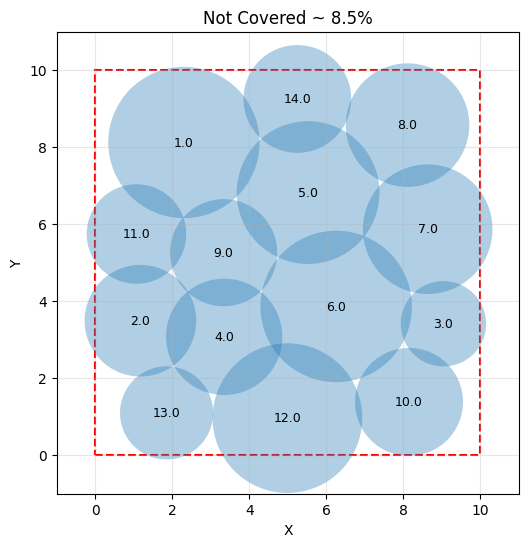

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Not Covered ~ 8.5%'}, xlabel='X', ylabel='Y'>)

In [46]:
# Single RUN
opt_centers, best_overall_metric = oc.get_optimal_coverege(init_type="init_data")
vis.visualize_stantions(opt_centers)

random


BEST: Step 988 | Loss: 0.0208 | Not Covered, %: 9.82 | LR: 0.3500
True


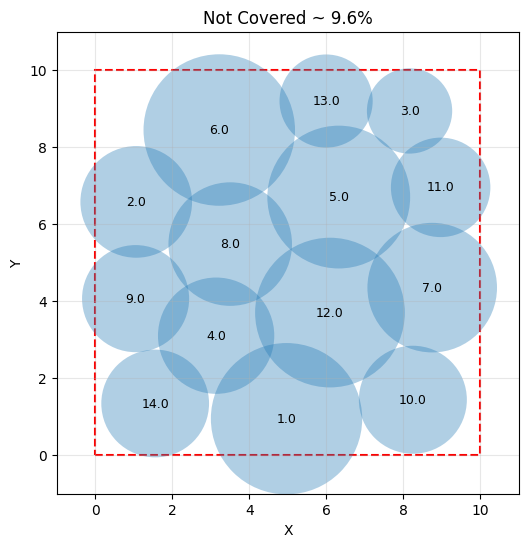

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Not Covered ~ 9.6%'}, xlabel='X', ylabel='Y'>)

In [60]:
# Single RUN
opt_centers, best_overall_metric = oc.get_optimal_coverege(init_type="random")
vis.visualize_stantions(opt_centers)


kmeans


BEST: Step 987 | Loss: 0.0175 | Not Covered, %: 7.27 | LR: 0.3500
True


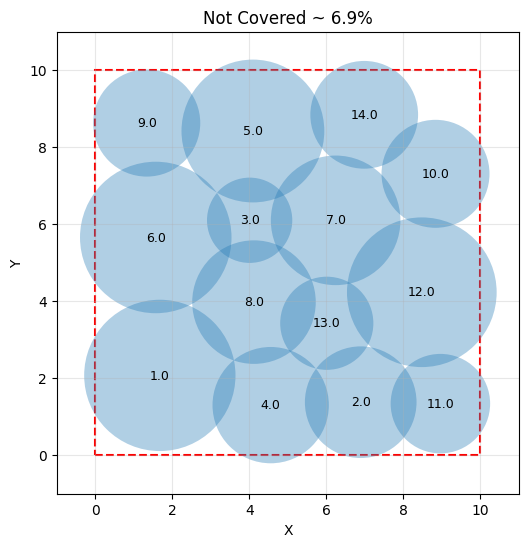

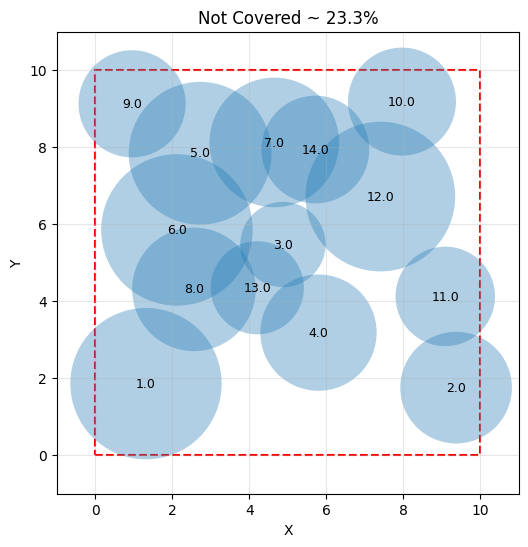

In [61]:
# Single RUN
opt_centers, best_overall_metric = oc.get_optimal_coverege(init_type="kmeans")
vis.visualize_stantions(opt_centers)
oc.vis_figures[0][0]

Оскільки це градієнтний метод, він чутливий до початкових умов і багатьох інших гіперпараметрів, щоб знайти краший можливий локальний мінімум, можна прогнати багато симуляцій з різними початковими ініціалізаціями і виграти кілька %


Starting Run 1/1...
random


BEST: Step 998 | Loss: 0.0192 | Not Covered, %: 8.15 | LR: 0.3500
New Global Best found: 8.15
True


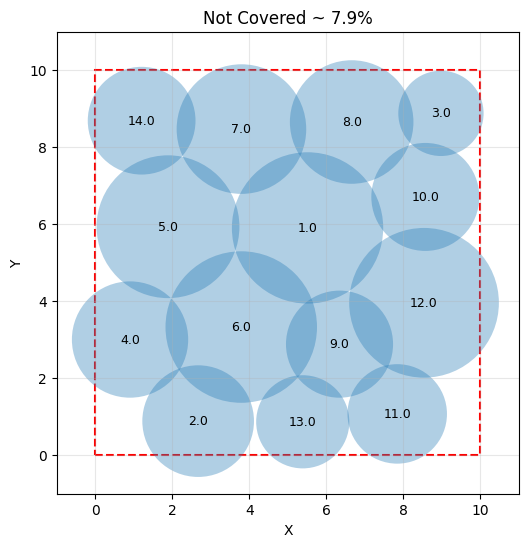

best_overall_metric=tensor(8.1536)


In [88]:
best_overall_df, best_overall_metric, best_vis = oc.run_multistart_optimization(n_runs=1)
vis.visualize_stantions(best_overall_df)
print(f"{best_overall_metric=}")

Збираємо 285 кадрів у GIF...
GIF успішно збережено як task_1_coverage_evolution.gif


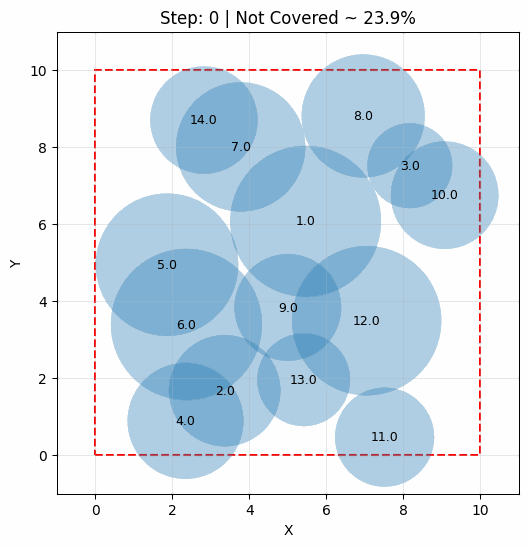

In [96]:
gif_vis = deepcopy(best_vis)
save_as_gif(gif_vis, fps = 10)